<a href="https://colab.research.google.com/github/mnslarcher/cs224w-slides-to-code/blob/main/notebooks/07-graph-neural-networks-2-design-space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # Check if PyTorch Geometric is installed:
    import torch_geometric
except ImportError:
    # If PyTorch Geometric is not installed, install it.
    %pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-geometric

# Graph Neural Networks 2: Design Space

In [2]:
import copy
from typing import Callable, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch_geometric.transforms as T
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Sequential
from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
data = dataset[0].to(device)

In [4]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]


def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    acc = accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    acc = accuracy(preds, y)
    return loss.item(), acc

In [5]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]


def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    seed: Optional[int] = 42,
    verbose: bool = True,
) -> HistoryDict:
    torch.manual_seed(seed)
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    min_loss = float("inf")
    early_stopping_counter = 0
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # Early stopping
        if val_loss < min_loss:
            min_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter == early_stopping:
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train. loss: {loss:.4f} | Train. acc: {acc:.4f}")
            print(f"  Val. loss: {val_loss:.4f} |   Val. acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history

In [6]:
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [7]:
# Hyper parameters that we will not change during the experiments:
HIDDEN_CHANNELS = 16
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4

# Classical GNN Layers: GCN

In [8]:
from torch_geometric.nn import GCN


Epoch: 0
----------
Train. loss: 2.7733 | Train. acc: 0.0357
  Val. loss: 2.7663 |   Val. acc: 0.1840

Epoch: 20
----------
Train. loss: 2.5375 | Train. acc: 0.9429
  Val. loss: 2.5901 |   Val. acc: 0.6440

Epoch: 40
----------
Train. loss: 2.3504 | Train. acc: 0.9857
  Val. loss: 2.4500 |   Val. acc: 0.6960

Epoch: 60
----------
Train. loss: 2.2099 | Train. acc: 0.9786
  Val. loss: 2.3425 |   Val. acc: 0.7020

Epoch: 80
----------
Train. loss: 2.1002 | Train. acc: 0.9786
  Val. loss: 2.2563 |   Val. acc: 0.7080

Epoch: 100
----------
Train. loss: 2.0123 | Train. acc: 0.9786
  Val. loss: 2.1858 |   Val. acc: 0.7220

Epoch: 120
----------
Train. loss: 1.9405 | Train. acc: 0.9786
  Val. loss: 2.1271 |   Val. acc: 0.7280

Epoch: 140
----------
Train. loss: 1.8811 | Train. acc: 0.9714
  Val. loss: 2.0775 |   Val. acc: 0.7360

Epoch: 160
----------
Train. loss: 1.8313 | Train. acc: 0.9714
  Val. loss: 2.0352 |   Val. acc: 0.7420

Epoch: 180
----------
Train. loss: 1.7893 | Train. acc: 0.97

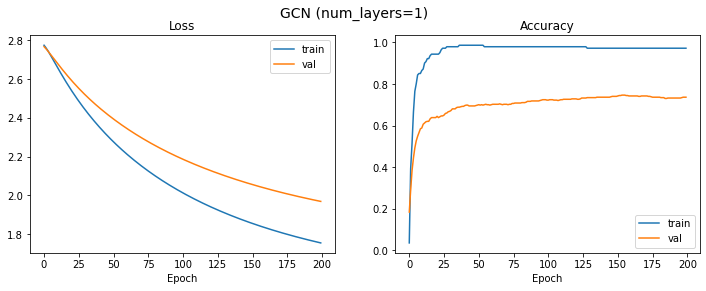

In [9]:
NUM_LAYERS = 1


model = GCN(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCN (num_layers={NUM_LAYERS})")

# Classical GNN Layers: GraphSAGE

In [10]:
from torch_geometric.nn import GraphSAGE


Epoch: 0
----------
Train. loss: 2.7756 | Train. acc: 0.0143
  Val. loss: 2.7628 |   Val. acc: 0.3240

Epoch: 20
----------
Train. loss: 2.4114 | Train. acc: 0.8571
  Val. loss: 2.5613 |   Val. acc: 0.6140

Epoch: 40
----------
Train. loss: 2.1289 | Train. acc: 0.8571
  Val. loss: 2.3998 |   Val. acc: 0.6340

Epoch: 60
----------
Train. loss: 1.9285 | Train. acc: 0.8571
  Val. loss: 2.2824 |   Val. acc: 0.6280

Epoch: 80
----------
Train. loss: 1.7886 | Train. acc: 0.8571
  Val. loss: 2.1962 |   Val. acc: 0.6380

Epoch: 100
----------
Train. loss: 1.6899 | Train. acc: 0.8571
  Val. loss: 2.1309 |   Val. acc: 0.6340

Epoch: 120
----------
Train. loss: 1.6183 | Train. acc: 0.8571
  Val. loss: 2.0801 |   Val. acc: 0.6380

Epoch: 140
----------
Train. loss: 1.4959 | Train. acc: 0.8571
  Val. loss: 1.9968 |   Val. acc: 0.6440

Epoch: 160
----------
Train. loss: 1.3424 | Train. acc: 0.9857
  Val. loss: 1.9025 |   Val. acc: 0.6540

Epoch: 180
----------
Train. loss: 1.2596 | Train. acc: 1.00

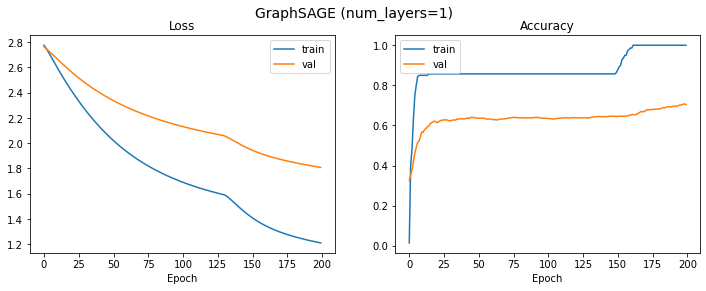

In [11]:
NUM_LAYERS = 1


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS})")

# GraphSAGE Neighbor Aggregation


Epoch: 0
----------
Train. loss: 2.7765 | Train. acc: 0.0071
  Val. loss: 2.7533 |   Val. acc: 0.3460

Epoch: 20
----------
Train. loss: 1.9043 | Train. acc: 1.0000
  Val. loss: 2.3072 |   Val. acc: 0.6820

Epoch: 40
----------
Train. loss: 1.3373 | Train. acc: 1.0000
  Val. loss: 1.9779 |   Val. acc: 0.7340

Epoch: 60
----------
Train. loss: 1.0267 | Train. acc: 1.0000
  Val. loss: 1.7855 |   Val. acc: 0.7480

Epoch: 80
----------
Train. loss: 0.8568 | Train. acc: 1.0000
  Val. loss: 1.6696 |   Val. acc: 0.7540

Epoch: 100
----------
Train. loss: 0.7548 | Train. acc: 1.0000
  Val. loss: 1.5910 |   Val. acc: 0.7480

Epoch: 120
----------
Train. loss: 0.6866 | Train. acc: 1.0000
  Val. loss: 1.5329 |   Val. acc: 0.7540

Epoch: 140
----------
Train. loss: 0.6374 | Train. acc: 1.0000
  Val. loss: 1.4878 |   Val. acc: 0.7440

Epoch: 160
----------
Train. loss: 0.6004 | Train. acc: 1.0000
  Val. loss: 1.4518 |   Val. acc: 0.7360

Epoch: 180
----------
Train. loss: 0.5717 | Train. acc: 1.00

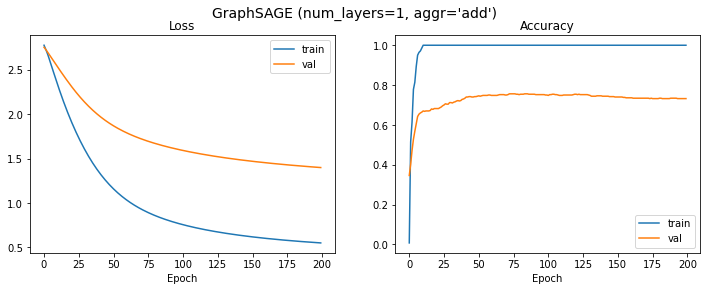

In [12]:
NUM_LAYERS = 1
AGGR = "add"


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, aggr=AGGR).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, aggr='{AGGR}')")

# GraphSAGE: L2 Normalization


Epoch: 0
----------
Train. loss: 2.8435 | Train. acc: 0.0143
  Val. loss: 2.6815 |   Val. acc: 0.3260

Epoch: 20
----------
Train. loss: 2.3079 | Train. acc: 0.5857
  Val. loss: 2.4983 |   Val. acc: 0.4260

Early stopping...

Epoch: 35
----------
Train loss: 2.2623 | Train acc: 0.6000
  Val loss: 2.4859 |   Val acc: 0.4240
 Test loss: 2.4688 |  Test acc: 0.4340


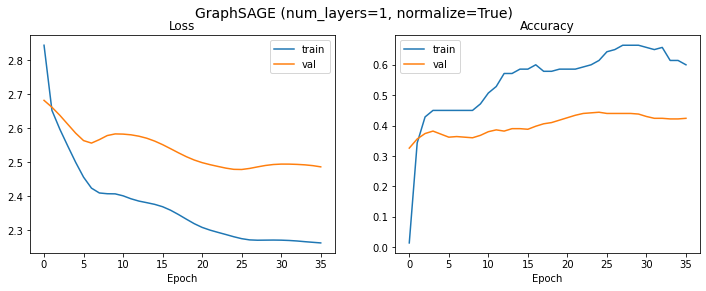

In [13]:
NUM_LAYERS = 1
NORMALIZE = True


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, normalize=NORMALIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, normalize={NORMALIZE})")

# Classical GNN Layers: GAT

In [14]:
from torch_geometric.nn import GAT


Epoch: 0
----------
Train. loss: 2.7733 | Train. acc: 0.0286
  Val. loss: 2.7642 |   Val. acc: 0.2900

Epoch: 20
----------
Train. loss: 2.5293 | Train. acc: 0.9643
  Val. loss: 2.5763 |   Val. acc: 0.7260

Epoch: 40
----------
Train. loss: 2.3363 | Train. acc: 0.9929
  Val. loss: 2.4282 |   Val. acc: 0.7400

Epoch: 60
----------
Train. loss: 2.1818 | Train. acc: 0.9929
  Val. loss: 2.3089 |   Val. acc: 0.7440

Epoch: 80
----------
Train. loss: 2.0104 | Train. acc: 0.9643
  Val. loss: 2.1940 |   Val. acc: 0.6980

Epoch: 100
----------
Train. loss: 1.8300 | Train. acc: 0.9643
  Val. loss: 2.0956 |   Val. acc: 0.6440

Epoch: 120
----------
Train. loss: 1.6535 | Train. acc: 0.9714
  Val. loss: 2.0110 |   Val. acc: 0.5820

Epoch: 140
----------
Train. loss: 1.5060 | Train. acc: 0.9786
  Val. loss: 1.9470 |   Val. acc: 0.5460

Epoch: 160
----------
Train. loss: 1.3888 | Train. acc: 0.9786
  Val. loss: 1.8910 |   Val. acc: 0.5360

Epoch: 180
----------
Train. loss: 1.2998 | Train. acc: 0.97

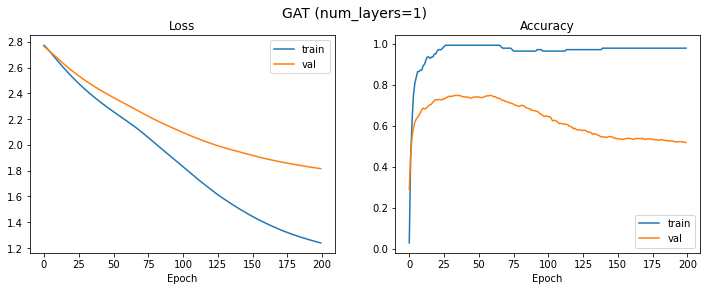

In [15]:
NUM_LAYERS = 1


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS})")

# Attention Mechanism

## Multi-head attention


Epoch: 0
----------
Train. loss: 2.7733 | Train. acc: 0.0286
  Val. loss: 2.7642 |   Val. acc: 0.2840

Epoch: 20
----------
Train. loss: 2.5295 | Train. acc: 0.9643
  Val. loss: 2.5765 |   Val. acc: 0.7240

Epoch: 40
----------
Train. loss: 2.3367 | Train. acc: 0.9929
  Val. loss: 2.4286 |   Val. acc: 0.7400

Epoch: 60
----------
Train. loss: 2.1857 | Train. acc: 0.9929
  Val. loss: 2.3118 |   Val. acc: 0.7480

Epoch: 80
----------
Train. loss: 2.0360 | Train. acc: 0.9714
  Val. loss: 2.2041 |   Val. acc: 0.7120

Epoch: 100
----------
Train. loss: 1.8701 | Train. acc: 0.9643
  Val. loss: 2.1065 |   Val. acc: 0.6640

Epoch: 120
----------
Train. loss: 1.7234 | Train. acc: 0.9571
  Val. loss: 2.0294 |   Val. acc: 0.5980

Epoch: 140
----------
Train. loss: 1.5929 | Train. acc: 0.9500
  Val. loss: 1.9677 |   Val. acc: 0.5620

Epoch: 160
----------
Train. loss: 1.4874 | Train. acc: 0.9500
  Val. loss: 1.9212 |   Val. acc: 0.5200

Epoch: 180
----------
Train. loss: 1.4117 | Train. acc: 0.96

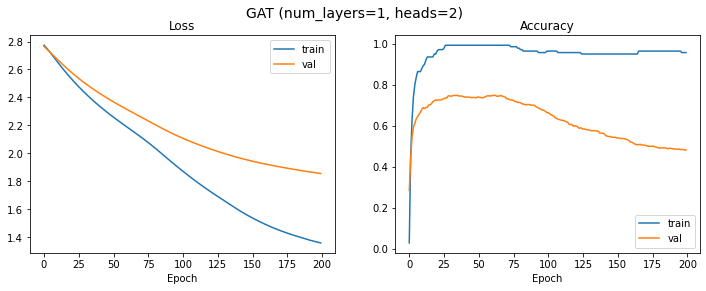

In [16]:
NUM_LAYERS = 1
HEADS = 2


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, heads=HEADS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, heads={HEADS})")

# GNN Layer in Practice

## Batch Normalization

In [17]:
from torch_geometric.nn import BatchNorm


Epoch: 0
----------
Train. loss: 2.9517 | Train. acc: 0.0714
  Val. loss: 2.7683 |   Val. acc: 0.1740

Epoch: 20
----------
Train. loss: 0.2380 | Train. acc: 0.9571
  Val. loss: 2.6226 |   Val. acc: 0.5540

Epoch: 40
----------
Train. loss: 0.1661 | Train. acc: 0.9571
  Val. loss: 2.4577 |   Val. acc: 0.4820

Epoch: 60
----------
Train. loss: 0.1341 | Train. acc: 0.9643
  Val. loss: 2.1967 |   Val. acc: 0.4860

Epoch: 80
----------
Train. loss: 0.1298 | Train. acc: 0.9643
  Val. loss: 1.9433 |   Val. acc: 0.4800

Epoch: 100
----------
Train. loss: 0.1275 | Train. acc: 0.9643
  Val. loss: 1.8875 |   Val. acc: 0.4720

Early stopping...

Epoch: 117
----------
Train loss: 0.1262 | Train acc: 0.9643
  Val loss: 1.8862 |   Val acc: 0.4700
 Test loss: 1.8876 |  Test acc: 0.4910


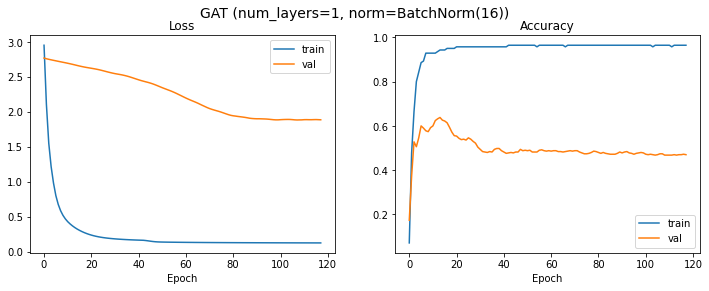

In [18]:
NUM_LAYERS = 1
NORM = BatchNorm(HIDDEN_CHANNELS)


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, norm=NORM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, norm={NORM})")

## Dropout


Epoch: 0
----------
Train. loss: 2.7738 | Train. acc: 0.0357
  Val. loss: 2.7659 |   Val. acc: 0.2720

Epoch: 20
----------
Train. loss: 2.5668 | Train. acc: 0.5000
  Val. loss: 2.6140 |   Val. acc: 0.7060

Epoch: 40
----------
Train. loss: 2.5088 | Train. acc: 0.4000
  Val. loss: 2.4941 |   Val. acc: 0.7160

Epoch: 60
----------
Train. loss: 2.3886 | Train. acc: 0.4643
  Val. loss: 2.4151 |   Val. acc: 0.7040

Epoch: 80
----------
Train. loss: 2.1840 | Train. acc: 0.5286
  Val. loss: 2.3447 |   Val. acc: 0.7180

Epoch: 100
----------
Train. loss: 2.3620 | Train. acc: 0.4071
  Val. loss: 2.2939 |   Val. acc: 0.7200

Epoch: 120
----------
Train. loss: 2.1975 | Train. acc: 0.5000
  Val. loss: 2.2689 |   Val. acc: 0.7140

Epoch: 140
----------
Train. loss: 2.2536 | Train. acc: 0.4357
  Val. loss: 2.2561 |   Val. acc: 0.6960

Epoch: 160
----------
Train. loss: 2.2206 | Train. acc: 0.4000
  Val. loss: 2.2343 |   Val. acc: 0.7160

Epoch: 180
----------
Train. loss: 2.0790 | Train. acc: 0.49

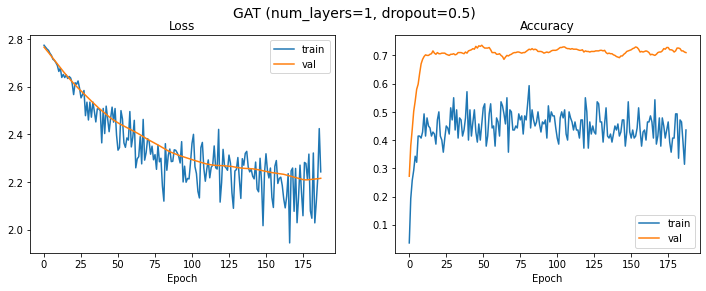

In [19]:
NUM_LAYERS = 1
DROPOUT = 0.5


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dropout=DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, dropout={DROPOUT})")

## Activation (Non-linearity)


Epoch: 0
----------
Train. loss: 3.2047 | Train. acc: 0.0429
  Val. loss: 2.7703 |   Val. acc: 0.1700

Epoch: 20
----------
Train. loss: 1.5352 | Train. acc: 0.5429
  Val. loss: 2.6451 |   Val. acc: 0.7400

Epoch: 40
----------
Train. loss: 1.6907 | Train. acc: 0.5214
  Val. loss: 2.4477 |   Val. acc: 0.7040

Epoch: 60
----------
Train. loss: 1.5806 | Train. acc: 0.5571
  Val. loss: 2.1406 |   Val. acc: 0.6320

Epoch: 80
----------
Train. loss: 1.3166 | Train. acc: 0.5714
  Val. loss: 1.8136 |   Val. acc: 0.6480

Epoch: 100
----------
Train. loss: 1.6247 | Train. acc: 0.4929
  Val. loss: 1.7208 |   Val. acc: 0.6240

Early stopping...

Epoch: 118
----------
Train loss: 1.7345 | Train acc: 0.4643
  Val loss: 1.7046 |   Val acc: 0.6200
 Test loss: 1.6530 |  Test acc: 0.6610


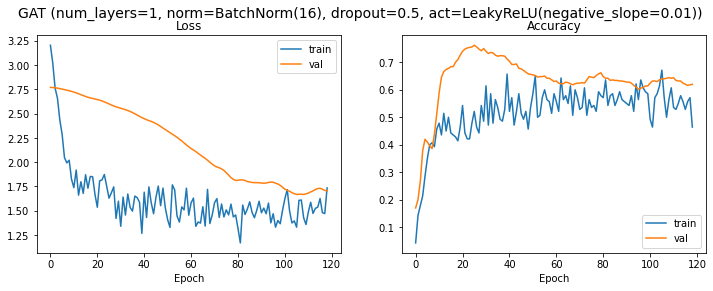

In [20]:
NUM_LAYERS = 1
NORM = BatchNorm(HIDDEN_CHANNELS)
DROPOUT = 0.5
ACT = torch.nn.LeakyReLU()


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, norm=NORM, dropout=DROPOUT, act=ACT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, norm={NORM}, dropout={DROPOUT}, act={ACT})")

# Stacking GNN Layers


Epoch: 0
----------
Train. loss: 2.7720 | Train. acc: 0.1500
  Val. loss: 2.7632 |   Val. acc: 0.1620

Epoch: 20
----------
Train. loss: 2.2248 | Train. acc: 0.2571
  Val. loss: 2.3206 |   Val. acc: 0.2100

Epoch: 40
----------
Train. loss: 1.6873 | Train. acc: 0.9286
  Val. loss: 1.8161 |   Val. acc: 0.7700

Epoch: 60
----------
Train. loss: 1.1154 | Train. acc: 0.8857
  Val. loss: 1.3929 |   Val. acc: 0.7160

Epoch: 80
----------
Train. loss: 0.6013 | Train. acc: 0.9429
  Val. loss: 1.1561 |   Val. acc: 0.7060

Epoch: 100
----------
Train. loss: 0.3211 | Train. acc: 0.9786
  Val. loss: 1.1176 |   Val. acc: 0.6480

Early stopping...

Epoch: 114
----------
Train loss: 0.2329 | Train acc: 0.9929
  Val loss: 1.1346 |   Val acc: 0.6360
 Test loss: 1.1595 |  Test acc: 0.6460


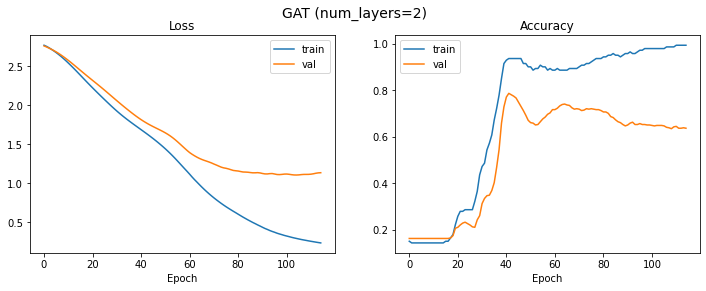

In [21]:
NUM_LAYERS = 2


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS})")

# Expressive Power for Shallow GNNs

In [22]:
class PrePostProc(torch.nn.Module):
    def __init__(
        self,
        model: torch.nn.Module,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_classes: int,
        num_pre_layers: int = 0,
        num_post_layers: int = 0,
        act: Callable[[Tensor], Tensor] = torch.nn.ReLU(inplace=True),
    ) -> None:
        super().__init__()

        self.model = model
        preproc = []
        postproc = []
        if num_pre_layers:
            preproc.append(torch.nn.Linear(in_channels, hidden_channels))
            preproc.append(act)

        for idx in range(num_pre_layers - 1):
            preproc.append(torch.nn.Linear(hidden_channels, hidden_channels))
            preproc.append(act)

        for idx in range(num_post_layers - 1):
            postproc.append(torch.nn.Linear(out_channels, out_channels))
            postproc.append(act)

        if num_post_layers:
            postproc.append(torch.nn.Linear(out_channels, num_classes))

        self.preproc = torch.nn.Sequential(*preproc)
        self.postproc = torch.nn.Sequential(*postproc)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.preproc(x)
        x = self.model(x, edge_index)
        x = self.postproc(x)
        return x


Epoch: 0
----------
Train. loss: 1.9542 | Train. acc: 0.1429
  Val. loss: 1.9598 |   Val. acc: 0.1620

Epoch: 20
----------
Train. loss: 1.9460 | Train. acc: 0.1429
  Val. loss: 1.9482 |   Val. acc: 0.1140

Early stopping...

Epoch: 21
----------
Train loss: 1.9460 | Train acc: 0.1429
  Val loss: 1.9485 |   Val acc: 0.1140
 Test loss: 1.9483 |  Test acc: 0.1030


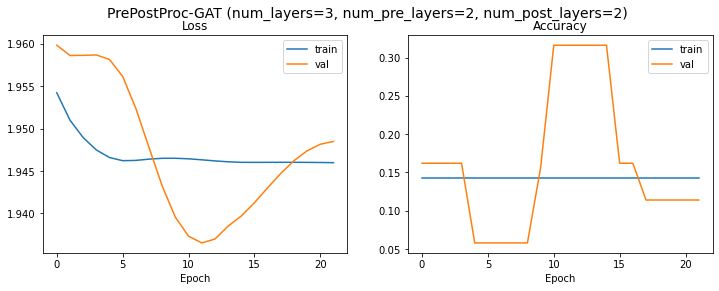

In [23]:
NUM_LAYERS = 3
NUM_PRE_LAYERS = 2
NUM_POST_LAYERS = 2

model = PrePostProc(
    model=GAT(HIDDEN_CHANNELS, HIDDEN_CHANNELS, NUM_LAYERS, out_channels=HIDDEN_CHANNELS),
    in_channels=dataset.num_node_features,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=HIDDEN_CHANNELS,
    num_classes=dataset.num_classes,
    num_pre_layers=NUM_PRE_LAYERS,
    num_post_layers=NUM_POST_LAYERS,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(
    history,
    f"PrePostProc-GAT (num_layers={NUM_LAYERS}, num_pre_layers={NUM_PRE_LAYERS}, num_post_layers={NUM_POST_LAYERS})",
)

# Design GNN Layer Connectivity

In [24]:
from torch_geometric.nn import GCNConv

In [25]:
class GCNConvBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
        add_skip: bool = False,
    ) -> None:
        super().__init__()
        self.conv = GCNConv(in_channels, in_channels, normalize=normalize)
        self.norm = copy.deepcopy(norm)
        self.act = act
        self.add_skip = add_skip

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        out = self.conv(x, edge_index)
        if self.norm is not None:
            out = self.norm(out)

        if self.add_skip:
            out += x

        if self.act is not None:
            out = self.act(out)

        return out

# Example: GCN with Skip Connections

In [26]:
class GCNSkip1(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        out_channels: int,
        dropout: float = 0.0,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
    ):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
        skip_blocks = []
        for _ in range(num_layers):
            skip_blocks.append(
                (
                    GCNConvBlock(hidden_channels, act=act, norm=norm, normalize=normalize, add_skip=True),
                    "x, edge_index -> x",
                )
            )

        self.skip_blocks = Sequential("x, edge_index", modules=skip_blocks)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.linear1(x)
        x = self.skip_blocks(x, edge_index)
        x = self.linear2(x)
        return x


Epoch: 0
----------
Train. loss: 1.9521 | Train. acc: 0.1429
  Val. loss: 1.9275 |   Val. acc: 0.1220

Epoch: 20
----------
Train. loss: 0.7920 | Train. acc: 0.8214
  Val. loss: 1.2486 |   Val. acc: 0.5760

Early stopping...

Epoch: 40
----------
Train loss: 0.0144 | Train acc: 1.0000
  Val loss: 1.1478 |   Val acc: 0.7200
 Test loss: 1.1860 |  Test acc: 0.7320


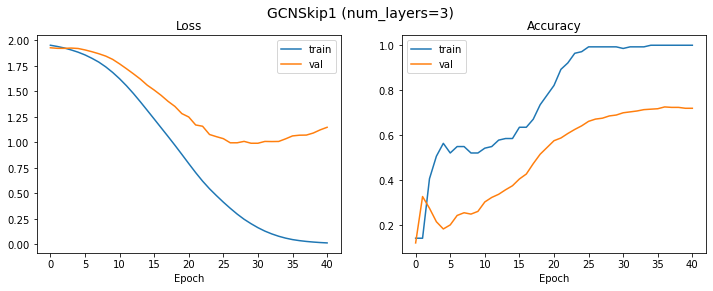

In [27]:
NUM_LAYERS = 3


model = GCNSkip1(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCNSkip1 (num_layers={NUM_LAYERS})")

# Other Option of Skip Connections

In [28]:
class GCNSkip2(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        out_channels: int,
        dropout: float = 0.0,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append((GCNConvBlock(hidden_channels, act=act, norm=norm, normalize=normalize)))

        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.linear1(x)
        outs = [x]
        for idx in range(self.num_layers):
            outs.append(self.convs[idx](outs[-1], edge_index))

        x = torch.mean(torch.stack(outs), axis=0)
        x = self.linear2(x)
        return x


Epoch: 0
----------
Train. loss: 1.9525 | Train. acc: 0.1429
  Val. loss: 1.9293 |   Val. acc: 0.1220

Early stopping...

Epoch: 10
----------
Train loss: 1.8996 | Train acc: 0.3143
  Val loss: 1.9316 |   Val acc: 0.1160
 Test loss: 1.9298 |  Test acc: 0.1380


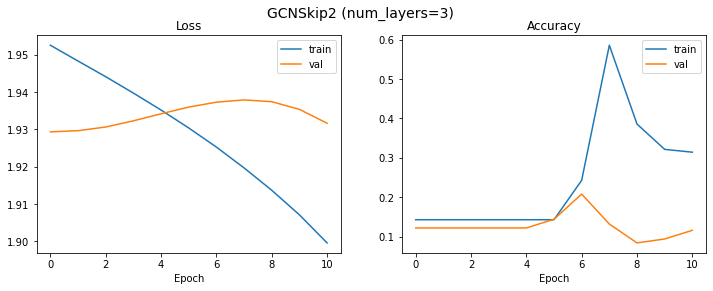

In [29]:
NUM_LAYERS = 3


model = GCNSkip2(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCNSkip2 (num_layers={NUM_LAYERS})")